In [2]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib
import os
np.set_printoptions(suppress=True, formatter={'float_kind':lambda x: "%.3f" % x})

def lorentzian(x, A, x0, gamma, k, b):
    return A / (1 + ((x - x0) / gamma)**2) + k * x + b
def double_lorentzian(x, A1, x1, gamma1, A2, x2, gamma2, k, b):
    return lorentzian(x, A1, x1, gamma1, k, b) + lorentzian(x, A2, x2, gamma2, 0, 0)
def triple_lorentzian(x, A1, x1, gamma1, A2, x2, gamma2, A3, x3, gamma3, k, b):
    return lorentzian(x, A1, x1, gamma1, k, b) + lorentzian(x, A2, x2, gamma2, 0, 0) + lorentzian(x, A3, x3, gamma3, 0, 0)
%pwd
polarizations = [ "zyyz", "zyxz" ]
x = {p: [[np.loadtxt(f'画图/拉曼结果拟合/combined/{p}/{w}/{s}/x.txt') for s in range(10)] for w in range(6)] for p in polarizations}
y = {p: [[np.loadtxt(f'画图/拉曼结果拟合/combined/{p}/{w}/{s}/y.txt') for s in range(10)] for w in range(6)] for p in polarizations}

In [3]:
fig = go.Figure()
for polarization in polarizations:
  for wafer in range(6):
    for site in range(10):
      fig.add_trace(go.Scatter(x=x[polarization][wafer][site], y=y[polarization][wafer][site], mode='lines', name=f'{polarization} {wafer} {site}'))
fig.update_layout(width=1920, height=1080)
fig.show()

In [4]:
def fitting_peek(x, y, x_range, function, guess, bound):
  mask = (x > x_range[0]) & (x < x_range[1])
  x = x[mask]
  y = y[mask]
  popt, pcov = curve_fit(function, x, y, p0=guess, maxfev=100000, bounds=bound)
  return popt
fitting_init_parameter = [
  [300, 196, 1, 2e3, 204, 0.8, 0, 900],
  [50, 266, 5, 0, 100],
  [1e3, 611, 5, 0, 100],
  [1e4, 776, 1, 1e3, 797, 1, 1, 100],
  [1e4, 776, 1, 1e4, 782, 1, 1e3, 797, 1, 1, 100],
  [1e4, 776, 1, 1, 100],
  [1e3, 797, 1, 1, 100],
]
fitting_range = [
  [180, 220],
  [250, 280],
  [600, 617],
  [700, 850],
  [700, 850],
  [700, 792],
  [793, 803],
]
fitting_bound = [
  ([0, 192, 0, 0, 200, 0, -np.inf, -np.inf], [np.inf, 198, np.inf, np.inf, 206, np.inf, np.inf, np.inf]),
  ([0, 260, 0, -np.inf, -np.inf], [np.inf, 270, np.inf, np.inf, np.inf]),
  ([0, 605, 0, -np.inf, -np.inf], [np.inf, 617, np.inf, np.inf, np.inf]),
  (-np.inf, np.inf),
  (-np.inf, np.inf),
  (-np.inf, np.inf),
  (-np.inf, np.inf)
]

In [5]:
A11_shift = {p: [[None for _ in range(10)] for _ in range(6)] for p in polarizations}
for polarization in polarizations:
  for wafer in range(6):
    for site in range(10):
      this_x = np.array(x[polarization][wafer][site])
      this_y = np.array(y[polarization][wafer][site])
      popt = fitting_peek(this_x, this_y, fitting_range[2], lorentzian, fitting_init_parameter[2], fitting_bound[2])
      A11_shift[polarization][wafer][site] = popt[1]
    print(f'{polarization} {wafer} {np.mean(A11_shift[polarization][wafer]):.3f} ± {np.std(A11_shift[polarization][wafer]):.3f}')

zyyz 0 609.746 ± 0.009
zyyz 1 609.741 ± 0.011
zyyz 2 609.773 ± 0.018
zyyz 3 609.782 ± 0.012
zyyz 4 609.759 ± 0.009
zyyz 5 609.740 ± 0.011
zyxz 0 609.606 ± 0.110
zyxz 1 609.595 ± 0.090
zyxz 2 609.661 ± 0.068
zyxz 3 609.641 ± 0.076
zyxz 4 609.685 ± 0.091
zyxz 5 609.643 ± 0.083


In [6]:
E21_shift = {p: [[None for _ in range(10)] for _ in range(6)] for p in polarizations}
E22_shift = {p: [[None for _ in range(10)] for _ in range(6)] for p in polarizations}
E22_E11_shift_diff = {p: [[None for _ in range(10)] for _ in range(6)] for p in polarizations}
for polarization in polarizations:
  for wafer in range(6):
    for site in range(10):
      this_x = np.array(x[polarization][wafer][site])
      this_y = np.array(y[polarization][wafer][site])
      popt = fitting_peek(this_x, this_y, fitting_range[0], double_lorentzian, fitting_init_parameter[0], fitting_bound[0])
      E21_shift[polarization][wafer][site] = popt[1]
      E22_shift[polarization][wafer][site] = popt[4]
      E22_E11_shift_diff[polarization][wafer][site] = popt[4] - popt[1]
for polarization in polarizations:
  for wafer in range(6):
    print(f'E21 {polarization} {wafer} {np.mean(E21_shift[polarization][wafer]):.3f} ± {np.std(E21_shift[polarization][wafer]):.3f}')
for polarization in polarizations:
  for wafer in range(6):
    print(f'E22 {polarization} {wafer} {np.mean(E22_shift[polarization][wafer]):.3f} ± {np.std(E22_shift[polarization][wafer]):.3f}')
for polarization in polarizations:
  for wafer in range(6):
    print(f'E22-E11 {polarization} {wafer} {np.mean(E22_E11_shift_diff[polarization][wafer]):.3f} ± {np.std(E22_E11_shift_diff[polarization][wafer]):.3f}')

E21 zyyz 0 195.514 ± 0.014
E21 zyyz 1 195.452 ± 0.024
E21 zyyz 2 195.529 ± 0.032
E21 zyyz 3 195.561 ± 0.019
E21 zyyz 4 195.562 ± 0.016
E21 zyyz 5 195.518 ± 0.022
E21 zyxz 0 195.470 ± 0.135
E21 zyxz 1 195.369 ± 0.101
E21 zyxz 2 195.529 ± 0.090
E21 zyxz 3 195.636 ± 0.123
E21 zyxz 4 195.675 ± 0.119
E21 zyxz 5 195.574 ± 0.169
E22 zyyz 0 203.438 ± 0.009
E22 zyyz 1 203.405 ± 0.017
E22 zyyz 2 203.513 ± 0.025
E22 zyyz 3 203.509 ± 0.014
E22 zyyz 4 203.484 ± 0.013
E22 zyyz 5 203.469 ± 0.010
E22 zyxz 0 203.411 ± 0.129
E22 zyxz 1 203.293 ± 0.103
E22 zyxz 2 203.495 ± 0.092
E22 zyxz 3 203.572 ± 0.109
E22 zyxz 4 203.591 ± 0.108
E22 zyxz 5 203.499 ± 0.164
E22-E11 zyyz 0 7.924 ± 0.015
E22-E11 zyyz 1 7.953 ± 0.018
E22-E11 zyyz 2 7.984 ± 0.016
E22-E11 zyyz 3 7.949 ± 0.010
E22-E11 zyyz 4 7.921 ± 0.010
E22-E11 zyyz 5 7.951 ± 0.016
E22-E11 zyxz 0 7.941 ± 0.025
E22-E11 zyxz 1 7.924 ± 0.014
E22-E11 zyxz 2 7.966 ± 0.022
E22-E11 zyxz 3 7.936 ± 0.031
E22-E11 zyxz 4 7.916 ± 0.024
E22-E11 zyxz 5 7.925 ± 0.015


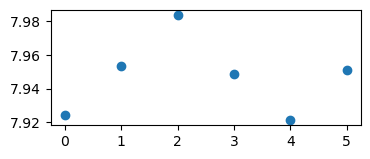

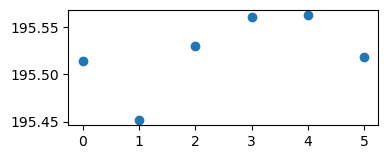

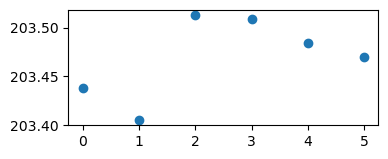

In [14]:
fig = plt.figure(figsize=(4, 1.5))
ax = fig.gca()
for i in range(6):
  ax.plot(i, np.mean(E22_E11_shift_diff['zyyz'][i]), 'o', color='C0')
fig = plt.figure(figsize=(4, 1.5))
ax = fig.gca()
for i in range(6):
  ax.plot(i, np.mean(E21_shift['zyyz'][i]), 'o', color='C0')
fig = plt.figure(figsize=(4, 1.5))
ax = fig.gca()
for i in range(6):
  ax.plot(i, np.mean(E22_shift['zyyz'][i]), 'o', color='C0')